import numpy as np
from scipy import constants
from scipy.optimize import leastsq
import uncertainties
from uncertainties import unumpy as unp
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
@uncertainties.wrap
def f(n=0, *P):
    ''' compute the nth root of the polynomial P and the uncertainty of the root'''
    p =  np.array(P)
    N = len(p)
    
    M = np.diag(np.ones((N-2,), p.dtype), -1)
    M[0, :] = -p[1:] / p[0]
    r = np.linalg.eigvals(M)
    r.sort()  # there is no telling what order the values come out in
    return r[n]

Molar masses

In [3]:
N0 = 70
M = {
    'P':31, 'N':14, 'C':12, 'O':8, 'H':1, 
    'F':19, 'Cl':35.5, 'Br':80, 'I':127}
M['head_Ph'] = 6 * M['C'] + 5 * M['O'] + 10 * M['H'] + M['P']
M['head_Et'] = 6 * M['C'] + 2 * M['O'] + 11 * M['H']
M['monoBr'] = 5 * M['C'] + 2 * M['O'] + 7 * M['H'] + M['Br']
M['Imidazolium'] = 4 * M['C'] + 6 * M['H'] + 2 * M['N']
M['Pyrrolidinium'] = 5 * M['C'] + 11 * M['H'] + M['N']
for short, full in [('Im', 'Imidazolium'), ('Pyr', 'Pyrrolidinium')]:
    for X in ['F','Cl','Br','I']:
        M['P'+short+X] = M['head_Ph'] + N0 * (M['monoBr'] + M[full] - M['Br'] + M[X])
        M['P'+short+X+'_Et'] = M['head_Et'] + N0 * (M['monoBr'] + M[full] - M['Br'] + M[X])

In [4]:
M

{'Br': 80,
 'C': 12,
 'Cl': 35.5,
 'F': 19,
 'H': 1,
 'I': 127,
 'Imidazolium': 82,
 'N': 14,
 'O': 8,
 'P': 31,
 'PImBr': 17303,
 'PImBr_Et': 17249,
 'PImCl': 14188.0,
 'PImCl_Et': 14134.0,
 'PImF': 13033,
 'PImF_Et': 12979,
 'PImI': 20593,
 'PImI_Et': 20539,
 'PPyrBr': 17513,
 'PPyrBr_Et': 17459,
 'PPyrCl': 14398.0,
 'PPyrCl_Et': 14344.0,
 'PPyrF': 13243,
 'PPyrF_Et': 13189,
 'PPyrI': 20803,
 'PPyrI_Et': 20749,
 'Pyrrolidinium': 85,
 'head_Et': 99,
 'head_Ph': 153,
 'monoBr': 163}

Other constants

In [5]:
T = constants.C2K(25) #temperature
b = 2.45*0.15e-9 # Kuhn length for a freely rotating chain of thetrahedral carbons
gK = 1.5 #number of monomers (2 carbons on the chain) in a Kuhn segment
lB = 0.7e-9 #Bjerum length
u = lB / b
print('u = {:0.2f}'.format(u))

u = 1.90


From now on, in dissociation order: PImBr, PImI, PPyrCl, PPyrBr, PPyrI

Monomer number density for a weight fraction of 80 g/kg

In [6]:
names = ['PImBr', 'PImI', 'PPyrCl', 'PPyrBr', 'PPyrI']
w = 80
c = N0 * constants.N_A / np.array([M[s] for s in names]) * 80 * 1000

Load strain sweeps at $f=1$ Hz.

In [7]:
sweeps = [
    np.loadtxt('ImBr_70_PO3_8pc_bis.strain', skiprows=5, usecols=[4,6,7]),
    np.loadtxt('PImI0CL70unit_80gperL.strain', skiprows=2),
    np.loadtxt('PPyCl0CL70unit_80gperL.strain', skiprows=2),
    np.loadtxt('PPyBr_70_0pc.strain', skiprows=5, usecols=[4,6,7])[:20],
    np.loadtxt('PPyI0CL70unit_80gperL_bis.strain', skiprows=5, usecols=[4,6,7]),
    ]

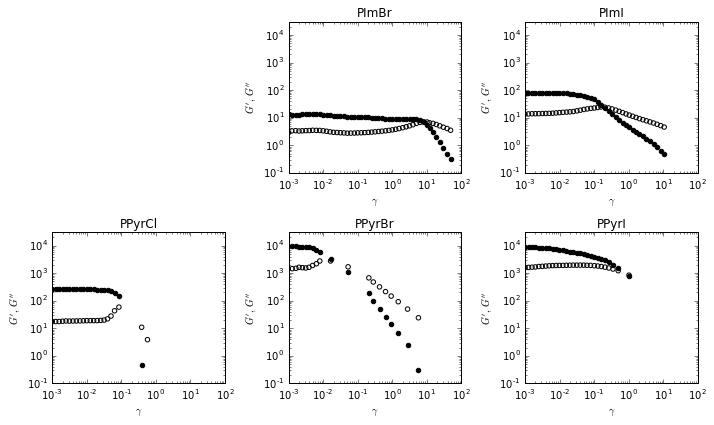

In [8]:
plt.figure(figsize=(10,6))
for i,(a,name) in enumerate(zip(sweeps,names)):
    plt.subplot(2,3,2+i)
    plt.title(name)
    plt.scatter(a[:,0], a[:,1], facecolors='k')
    plt.scatter(a[:,0], a[:,2], edgecolors='k', facecolors='none')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-3,1e2)
    plt.ylim(1e-1,3e4)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$G^\prime,\, G^{\prime\prime}$')
plt.tight_layout()

All 5 samples are solidlike ($G^\prime \gg G^{\prime\prime}$) at small strains and flow at large strains ($G^{\prime\prime} \gg G^\prime$) with a steep decrease of the moduli. Moderatly charged PImI and PPyrCl show a plateau in both moduli at low strain corresponding to the linear regime of the material; an overshoot of $G^{\prime\prime}$ and a downward slope of $G^\prime$ at intermediate strains corresponding to the onset of plasticity~\cite{Hyun2011}; and a decrease of both moduli at large strains, steeper for $G^\prime$ than for $G^{\prime\prime}$, indicating shear thinning. The linear regime is either extremely narrow or non existent in heavily charged PPyrBr and PPyrI. By contrast the lightly charged PImBr displays a broad intermediate regime (tree decades of strain) between the linear regime and the crossing of the moduli.

Measure $G'(\gamma \rightarrow 0)$ and the error

In [9]:
G = unp.uarray(
    [a[0,1] for a in sweeps],
    np.abs([(a[0,1]-a[1,1])/2 for a in sweeps])
)
for name, g in zip(names, G):
    print('{}:\tG\' = {:10.4P} Pa\trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	G' =      13.28±      0.19 Pa	relative error: 1.43%
PImI:	G' =      78.56±      0.13 Pa	relative error: 0.17%
PPyrCl:	G' =      272.3±       0.6 Pa	relative error: 0.20%
PPyrBr:	G' =       9811±        40 Pa	relative error: 0.40%
PPyrI:	G' =       8796±        34 Pa	relative error: 0.38%


Measure the critical strain $\gamma_c$ such that the moduli cross, and the error.

In [10]:
imaxs = np.array([np.where(a[:,2]<a[:,1])[0][-1] for a in sweeps])
gamma_c = unp.uarray(
    np.exp([
        np.interp(0, np.log(a[imax:imax+2,2]/a[imax:imax+2,1]), np.log(a[imax:imax+2,0])) 
        for a,imax in zip(sweeps, imaxs)
        ]),
    [(a[imax+1,0]-a[imax,0])/2 for a,imax in zip(sweeps, imaxs)]
    )
for name, g in zip(names, gamma_c):
    print('{}:\tgamma_c\' = {:10P}\trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	gamma_c' =        8.1±       1.0	relative error: 12.88%
PImI:	gamma_c' =      0.184±     0.024	relative error: 13.11%
PPyrCl:	gamma_c' =       0.12±      0.15	relative error: 124.44%
PPyrBr:	gamma_c' =      0.022±     0.018	relative error: 82.26%
PPyrI:	gamma_c' =       0.89±      0.26	relative error: 29.38%


Estimate the end of the linear regime.

In [11]:
#i0 = np.array([np.where((a[:,2] > 1.15 *a[:np.argmax(a[:,2]),2].min()) & (a[:,1] < 0.95 * a[0,1].max()))[0][0] for a in sweeps])
i0 = np.array([10, 12, 14, 5, 0])
gamma_c0 = unp.uarray(
    [np.exp((np.log(a[imax,0])+np.log(a[imax+1,0]))/2) for a,imax in zip(sweeps, i0)],
    [(a[imax+1,0]-a[imax,0])/2 for a,imax in zip(sweeps, i0)]
    )
for name, g in zip(names, gamma_c0):
    print('{}:\tgamma_c0\' = {:10P}\trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	gamma_c0' =     0.0112±    0.0013	relative error: 11.35%
PImI:	gamma_c0' =     0.0179±    0.0020	relative error: 11.16%
PPyrCl:	gamma_c0' =     0.0283±    0.0032	relative error: 11.21%
PPyrBr:	gamma_c0' =     0.0035±    0.0004	relative error: 10.95%
PPyrI:	gamma_c0' =    0.00113±   0.00013	relative error: 11.45%


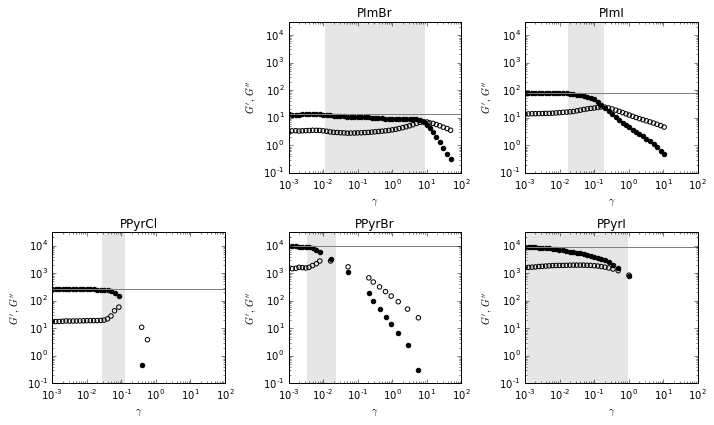

In [12]:
plt.figure(figsize=(10,6))
for i,(a,name, gc0, gc) in enumerate(zip(sweeps,names, gamma_c0, gamma_c)):
    plt.subplot(2,3,2+i)
    plt.title(name)
    plt.axvspan(gc0.n,gc.n, color=(0.9,0.9,0.9), zorder=-1)
    plt.axhline(a[0,1],color=[0.5]*3)
    plt.scatter(a[:,0], a[:,1], facecolors='k')
    plt.scatter(a[:,0], a[:,2], edgecolors='k', facecolors='none')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-3,1e2)
    plt.ylim(1e-1,3e4)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$G^\prime,\, G^{\prime\prime}$')
plt.tight_layout()

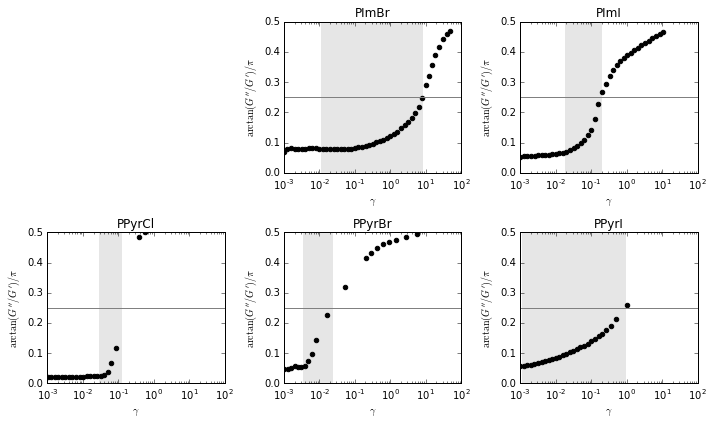

In [13]:
plt.figure(figsize=(10,6))
for i,(a,name, gc0, gc) in enumerate(zip(sweeps,names, gamma_c0, gamma_c)):
    plt.subplot(2,3,2+i)
    plt.title(name)
    plt.axvspan(gc0.n,gc.n, color=(0.9,0.9,0.9), zorder=-1)
    plt.axhline(0.25,color=[0.5]*3)
    plt.scatter(a[:,0], np.arctan2(a[:,2],a[:,1])/np.pi, facecolors='k')
    #plt.scatter(a[:,0], a[:,2], edgecolors='k', facecolors='none')
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlim(1e-3,1e2)
    plt.ylim(0,0.5)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\arctan(G^{\prime\prime}/G^\prime)/\pi$')
plt.tight_layout()

## Linear regime till the end

In absence of strain, the structure of a polyelectrolyte chain is organised at various scales.

The smallest scale is the Kuhn length $b$ containing $g_\mathrm{K}$ monomers. For a freely joint chain of tetrahedral carbons $b\approx 367$ pm. Since a monomer counts 2 carbons along the chain $g_\mathrm{K}\approx 3/2$.


Since we are in bad solvent, the thermal length $\xi_T$ is larger than $b$. The thermal blob contains $g_T$ monomers and its density is set by the reduced temperature $(g_T/g_\mathrm{K})/\xi_T^3 = \tau/b^3$. Between $b$ and $\xi_T$ we have a persistent random walk $\xi_T = b (g_T/g_\mathrm{K})^{1/2}$. These conditions yields $\xi_T = b/\tau$ and $g_T = g_\mathrm{K}/\tau^2$.

At a scale $D$, the electrostatic energy balances the surface energy of the collapsed polymer. We name $g_e$ the number of monomers in the electrostatic blob. If there is a charge every $A$ monomers and there are $g_e/A$ charges in the electrostatic blob. The surface tension is proportional to the number of thermal blobs exposed on the surface $k_\mathrm{B}T/\xi_T^2$, with $k_\mathrm{B}$ is the Boltzmann constant and $T$ the temperature. Thus the balance of energies writes:
$$\left(\frac{D}{\xi_T}\right)^2 = \left(\frac{g_e}{A}\right)^2 \frac{\ell_\mathrm{B}}{D},$$
where $\ell_\mathrm{B} = e^2/(4\pi\epsilon k_\mathrm{B}T)$ is the Bjerrum length with $e$ the elementary charge, $\epsilon$ the dielectric constant of the solvent. Since thermal blobs fill the volume of the electrostatic blob $D = \xi_T \left(g_e/g_T\right)^{1/3}$, we obtain
$$g_e = \frac{A^2}{u g_\mathrm{K}} \tau, \qquad D = b\left(\frac{A^2}{u g_\mathrm{K}^2}\right)^{1/3},\qquad \text{with }u = \ell_\mathrm{B}/b.$$

We define the extension parameter $B$ as the ratio between the length of a chain of $g_e$ monomers fully extended and the actual size of the electrostatic blob: 
$$B = \frac{g_e}{g_\mathrm{K}}\frac{b}{D} = \left(\frac{A^2}{u}\right)^{2/3} g_\mathrm{K}^{-1/3}\tau$$

We want to evaluate $B$ since it is monotonically related to the amount of counterion condensation (at constant solvent quality).

Electrostatic repulsion decays with a characteristic length $r_\mathrm{src}$, the screening length. In general this screening length is set by the concentration of dissociated counterions and the concentration of $c_s$ added salts.
Between $D$ and $r_\mathrm{src}$ the electrostatic blobs are organised in a linear rod containing $g_\mathrm{src}$ monomers. The length of this rod is $B$ times shorter than if the electrostatic blobs were extended: 
$$r_\mathrm{src} = \frac{g_\mathrm{src} b}{g_\mathrm{K}B}$$

The last length scale is the correlation length $\xi$. Between $r_\mathrm{src}$ and $\xi$ the chain forms a self avoiding walk of persistence length $r_\mathrm{src}$.

Above the correlation length the polyelectrolyte chain forms a random walk of correlation blobs containing $g=c\xi^3$ monomers.

A chain perfoming a random walk or self avoiding walk can be considered an entropic spring of constant stiffness $k_\mathrm{B}T$. The number density of chains is $c/N$ with $c$ the monomer concentration and $N=n N_0$ the number of monomers between cross-links or entanglements. Therefore, the shear modulus at low strain is given by:
$$G = \frac{c}{N}k_\mathrm{B}T.$$

Conversly, we extract the number $n$ of polymers between crosslinks or entanglements from $G'(\gamma \rightarrow 0)$.

In [14]:
T = constants.C2K(25)
n = c/N0 * constants.k * T / G
for name, g in zip(names, n):
    print('{}:\tn = {:10P}\trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	n =        863±        12	relative error: 1.43%
PImI:	n =     122.59±      0.20	relative error: 0.17%
PPyrCl:	n =      50.58±      0.10	relative error: 0.20%
PPyrBr:	n =      1.154±     0.005	relative error: 0.40%
PPyrI:	n =      1.084±     0.004	relative error: 0.38%


As the material is strained, the random walk is stretched, then the self-avoiding walk. When the correlation blobs are fully streched, the chain is a linear assembly of electrostatic blobs. Stretching the chain further means exposing more monomer to the solvent, a process that cannot be reduced to spring of constant stiffness. This condition is thus the limit between the linear and non linear regimes.

For all our samples, the linear regime is narrow $\gamma_0\approx 10^{-2}\ll 1$ if existing. It means that the self-avoiding walk is very short and the random walk probably non existent (the chain is too short). In other words the number $N$ of monomer between crosslinks is comparable to $g_\mathrm{scr}$. We are thus dealing with a semiflexible filament network\cite{MacKintosh1995,Meng2016}. Shearing a permanent network of semiflexible filaments implies fibrer buckling\cite{Meng2016} and strong shear thickening. Here the processions are able to break apart (decrease in $G^\prime$) and reform (maximum in $G^{\prime\prime}$). The picture in the plastic regime is even more complex due to stress localisation on the remaining processions. Therefore, we focus on the simpler case of the exit from the linear regime. 

In dilute solution, the chain is a linear rod of length $$L= \frac{N b}{g_\mathrm{K}B}.$$

The overlap concentration is thus $$c^* = \frac{N}{L^3} = \frac{g_\mathrm{K}B}{b L^2}.$$

Following \cite{Dobrynin1995}, the screening length in abscence of salt is 
$$r_\mathrm{src} = L \left(\frac{c^*}{c}\right)^{1/2} =  \left(\frac{g_\mathrm{K}B}{cb}\right)^{1/2}$$

In the presence of added salt, electrostatic interactions are screened at the Debye length
$$r_\mathrm{src} = \left(\ell_\mathrm{B} c_s\right)^{-1/2}.$$

For arbitrary salt concentration,
$$r_\mathrm{src} = \left(\frac{g_\mathrm{K}B}{cb}\right)^{1/2} \left(1+ g_\mathrm{K}Bu \frac{c_s}{c}\right)^{-1/2}.$$

We deduce the number of monomers in the rod 
$$g_\mathrm{src} = g_\mathrm{K} B \frac{r_\mathrm{src}}{b} = \left(\frac{g_\mathrm{K}^3 B^3}{cb^3}\right)^{1/2} \left(1 + g_\mathrm{K}Bu \frac{c_s}{c}\right)^{-1/2}.$$

Let us note
$$B_s = \frac{c}{g_\mathrm{K} u c_s}$$
$$B_0 = b c^{1/3} N^{2/3} g_\mathrm{K}^{-1} = \frac{bc}{g_\mathrm{K}} \left(\frac{k_\mathrm{B}T}{G}\right)^{2/3}$$

The condition $g_\mathrm{src}\approx N$ writes
$$\left(\frac{B}{B_0}\right)^3 = 1 + \frac{B}{B_s}$$

This equation can be solved numerically to yield B. Nonetheless, we identify two physically relevant limit cases:

- if $B \ll B_s$ (low salt condition) then $B = B_0$

- if $B \gg B_s$ (high salt condition) then $B = \left(\frac{B_0^3}{B_s}\right)^{1/2} > B_0$

Here, the "salt" are the phosphonate heads, that is to say two charges per chain. Thus $c_s/c = 2/N_0$ and $B_s = N_0/2g_\mathrm{K}u$.

In [15]:
Bs = N0/u/2/gK
print('Bs = {:g}'.format(Bs))

Bs = 12.25


In [17]:
print('Supposing low salt')
B0 = b * c * (constants.k * T / G)**(2/3) / gK
for name, g in zip(names, B0):
    print('{}:\tB0 = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

Supposing low salt
PImBr:	B0 =      218.7±       2.1 	relative error: 0.95%
PImI:	B0 =      56.18±      0.06 	relative error: 0.11%
PPyrCl:	B0 =      35.08±      0.05 	relative error: 0.13%
PPyrBr:	B0 =      2.644±     0.007 	relative error: 0.27%
PPyrI:	B0 =      2.394±     0.006 	relative error: 0.25%


In [18]:
print('Supposing high salt')
for name, g in zip(names, (B0**3 / Bs)**(1/2)):
    print('{}:\tB1 = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

Supposing high salt
PImBr:	B1 =        924±        13 	relative error: 1.43%
PImI:	B1 =     120.32±      0.20 	relative error: 0.17%
PPyrCl:	B1 =      59.38±      0.12 	relative error: 0.20%
PPyrBr:	B1 =      1.228±     0.005 	relative error: 0.40%
PPyrI:	B1 =      1.058±     0.004 	relative error: 0.38%


Numerical solution

In [19]:
B = np.array([
        f(2, 1/(b0**3),0,-1/Bs,-1)
        for b0 in B0
        ])
for name, g in zip(names, B):
    print('{}:\tB = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	B =        930±        13 	relative error: 1.42%
PImI:	B =     126.03±      0.20 	relative error: 0.16%
PPyrCl:	B =      64.75±      0.12 	relative error: 0.19%
PPyrBr:	B =      2.834±     0.008 	relative error: 0.29%
PPyrI:	B =      2.550±     0.007 	relative error: 0.27%


/home/mathieu/anaconda3/lib/python3.5/site-packages/uncertainties/core.py:1538: ComplexWarning: Casting complex values to real discards the imaginary part
  self._nominal_value = float(nominal_value)


For the same quality of solvent $B$ is monotonically related to the amount of counterion condensation. We thus confirm that our samples are sorted by decreasing counterion condensation (decreasing $B$). More quantitatively, the number $A$ of monomers between dissociated charges is
$$A = u^{1/2} g_\mathrm{K}^{1/4} \left(\frac{B}{\tau}\right)^{3/4}$$
where $u = b/\ell_\mathrm{B}$, with $\ell_\mathrm{B} = 0.7$ nm the Bjerrum length in water and $\tau = 1-T/\Theta$ the reduced temperature. 

We know that $\Theta>100$°C so $0.2<\tau<1$. In the following we will deduce a more precise measure of $\tau$ and thus values of $A$.

## Extention of the electrostatic blobs

If we neglect the extension of the self-avoiding walk, appying a strain $\gamma$ to the material implies stretching the rod to a length $R = (\gamma+1)N b /B$ and thus exposing more monomers to the solvent. The maximum extention is reached for $R = Nb/g_K$ or $\gamma+1=B$.

In [23]:
gamma_c+1 < B

array([ True,  True,  True,  True,  True], dtype=bool)

The fully extended self-avoiding walk is a cylinder of length $R_0 = Nb/B$, of diameter $D$, of volume $V = R_0 D^2$ and of area $\Sigma_0 = R_0 D = (R_0 V)^{1/2}$. Extending the cylinder to $R$ while keeping the volume $V$ constant thus creates an extra area 
$$\Delta\Sigma = \left(\left(\gamma +1\right)^{1/2} -1\right) \frac{N b}{g_\mathrm{K} B}D$$
that translates into a stretching energy due to the surface tension $k_\mathrm{B}T/\xi_T^2$:
$$\frac{E}{k_\mathrm{B}T} = \left(\left(\gamma +1\right)^{1/2} -1\right) \frac{N b}{g_\mathrm{K} B\xi_T^2}D = \left(\left(\gamma +1\right)^{1/2} -1\right) N \left(\frac{\tau^3}{g_\mathrm{K}^5B}\right)^{1/2} $$

If we consider that the head-to-body bonds break at $\gamma_c$, we can express the reduced temperature as
$$\tau = B^{1/3} g_\mathrm{K}^{5/3} \left(\frac{1}{(\gamma_c +1)^{1/2} -1}\frac{E_c}{N k_\mathrm{B}T}\right)^{2/3}$$
where $E_c$ is the energy of the head-to-body bond.

The head-to-body bond consists in two ionic bonds, each typically $5\pm 1$ kJ/mol in water\cite{Schneider1992}, thus $E_c\approx 2 k_\mathrm{B}T$. However the medium surrounding the ionic bond is not water. One has to keep in mind that the chain is in bad solvent, thus forming locally compact blobs of low water content. Such a low polarity microenvironement is well known to enhance otherwise weak electrostatic interactions in protein folding or engineered self-assembly\cite{Rehm2010}. We thus expect stronger head-to-body bonds when $B$ is large and the low-polarity environement is extended. A contrario, the weakest ionic links, closest to their strength in water, should be found in \ce{PPyr+I-} where $B$ is minimum.

In [31]:
Ec0 = uncertainties.ufloat(5e3,1e3) / (constants.N_A* constants.k * T)
print('bonding energy {:P} kT'.format(Ec0))
tau = B[-1]**(1/3) * gK**(5/3) * (Ec0 / (n[-1] * N0 * ((1+gamma_c[-1])**(1/2) -1)))**(2/3)
print('tau = {:P}\trelative error: {:0.2f}%\tTheta >= {:P} °C'.format(
        tau,
        100*tau.s/tau.n, 
        constants.K2C(T/(1-tau))
    ))

bonding energy 2.0±0.4 kT
tau = 0.46±0.10	relative error: 21.54%	Theta >= (2.8±1.0)×10² °C


We can then obtain the bonding energies:

In [32]:
Ec = ((1+gamma_c[-1])**(1/2) -1) * (n*N0) * (tau**3/gK**5/B)**(1/2)
for name, g in zip(names, Ec):
    print('{}:\tEc = {:P} kT = {:.4P} kJ/mol \trelative error: {:0.2f}'.format(
            name, g, 
            g * constants.k * T * constants.N_A / 1000, 
            100*g.s/g.n))

PImBr:	Ec = 84±17 kT = 208.5±41.7 kJ/mol 	relative error: 20.01
PImI:	Ec = 32±6 kT = 80.44±16.09 kJ/mol 	relative error: 20.00
PPyrCl:	Ec = 19±4 kT = 46.31±9.26 kJ/mol 	relative error: 20.00
PPyrBr:	Ec = 2.0±0.4 kT = 5.051±1.010 kJ/mol 	relative error: 20.00
PPyrI:	Ec = 2.0±0.4 kT = 5.000±1.000 kJ/mol 	relative error: 20.00


In [33]:
Ec[0]/140

0.6006677362436003+/-0.12022045811607539

In the most dissociated PPyrI and PPyrBr, the head-to-body bonding energy $E_c$ is within the range of typical ionic bonds, $5\pm 1$ kJ/mol in water\cite{Schneider1992}. However the bonding energy increases with increasing counterion condensation to reach 85% of the carbon-carbon single bond (350 kJ/mol or $140 k_\mathrm{B}T$) in the case of PImBr. Indeed, at high counterion condensation, the electrostatic blobs are large, up to 530 polymers for PImBr, and embed head-to-body bonds into compact blobs of low water content. Such a low polarity microenvironement is well known to enhance otherwise weak electrostatic interactions in protein folding or engineered self-assembly\cite{Rehm2010}.

$$g_e = \left(\frac{B^3}{g_\mathrm{K}\tau}\right)^{1/2}$$

In [36]:
for name, g in zip(names, (B**3/gK/tau)**(1/2) / N0):
    print('{}:\tge/N0 = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	ge/N0 =    4.9×10²±   0.5×10² 	relative error: 10.98%
PImI:	ge/N0 =       24.3±       2.6 	relative error: 10.77%
PPyrCl:	ge/N0 =        9.0±       1.0 	relative error: 10.77%
PPyrBr:	ge/N0 =      0.082±     0.009 	relative error: 10.78%
PPyrI:	ge/N0 =      0.070±     0.008 	relative error: 10.78%


$$D = \frac{b g_e}{B g_\mathrm{K}} = \left(\frac{B}{g_\mathrm{K}^3\tau}\right)^{1/2} b$$

In [37]:
for name, g in zip(names, (B/gK**3/tau)**(1/2)*b/lB):
    print('{}:\tD/lB = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	D/lB =       12.9±       1.4 	relative error: 10.79%
PImI:	D/lB =        4.7±       0.5 	relative error: 10.77%
PPyrCl:	D/lB =        3.4±       0.4 	relative error: 10.77%
PPyrBr:	D/lB =       0.71±      0.08 	relative error: 10.77%
PPyrI:	D/lB =       0.67±      0.07 	relative error: 10.77%


Quantitatively, the bonding energy of an ionic bond is inversely proportional to the relative dielectric constant $\epsilon_r$, therefore we need to suppose a local $\epsilon_r$ around 2 (typical of water-insoluble polymers) instead of 80 for water to recover the large bonding energy that we measure.

In [26]:
80*Ec[-1]/Ec[0]

1.9187954340239923+/-0.014600142515576047

From this value of $\tau$ we also obtain $A$

In [34]:
A = u**(1/2) * gK**(1/4) *(B/tau)**(3/4)
for name, g in zip(names, A):
    print('{}:\tA = {:P}\tN0/A = {:P}\tA/N0 = {:P}\trelative error: {:0.2f}'.format(name, g, N0/g, g/N0, 100*g.s/g.n))

PImBr:	A = (4.6±0.7)×10²	N0/A = 0.152±0.025	A/N0 = 6.6±1.1	relative error: 16.19
PImI:	A = 103±17	N0/A = 0.68±0.11	A/N0 = 1.47±0.24	relative error: 16.16
PPyrCl:	A = 62±10	N0/A = 1.12±0.18	A/N0 = 0.89±0.14	relative error: 16.16
PPyrBr:	A = 6.0±1.0	N0/A = 11.7±1.9	A/N0 = 0.085±0.014	relative error: 16.16
PPyrI:	A = 5.5±0.9	N0/A = 12.7±2.1	A/N0 = 0.079±0.013	relative error: 16.16


### Some geometry

How many monomers are contained in an electrostatic blob ?
$$g_e = \left(\frac{B^3}{g_\mathrm{K}\tau}\right)^{1/2}$$

In [39]:
for name, g in zip(names, (B**3/gK/tau)**(1/2)):
    print('{}:\tge = {:10.4P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	ge =  3.415×10⁴± 0.375×10⁴ 	relative error: 10.98%
PImI:	ge =       1703±       183 	relative error: 10.77%
PPyrCl:	ge =      627.2±      67.6 	relative error: 10.77%
PPyrBr:	ge =      5.744±     0.619 	relative error: 10.78%
PPyrI:	ge =      4.902±     0.528 	relative error: 10.78%


Or in number of chains per electrostatic blobs

In [40]:
for name, g in zip(names, (B**3/gK/tau)**(1/2) / N0):
    print('{}:\tge/N0 = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	ge/N0 =    4.9×10²±   0.5×10² 	relative error: 10.98%
PImI:	ge/N0 =       24.3±       2.6 	relative error: 10.77%
PPyrCl:	ge/N0 =        9.0±       1.0 	relative error: 10.77%
PPyrBr:	ge/N0 =      0.082±     0.009 	relative error: 10.78%
PPyrI:	ge/N0 =      0.070±     0.008 	relative error: 10.78%


Number of electrostatic blobs per rod
$$\frac{g_\mathrm{src}}{g_e} \approx N\left(\frac{B^3}{g_\mathrm{K}\tau}\right)^{-1/2}$$

In [43]:
for name, g in zip(names, n*N0*(B**3/gK/tau)**(-1/2)):
    print('{}:\tg_scr/ge = {:0.2f}'.format(name,g))

PImBr:	g_scr/ge = 1.77+/-0.19
PImI:	g_scr/ge = 5.04+/-0.54
PPyrCl:	g_scr/ge = 5.65+/-0.61
PPyrBr:	g_scr/ge = 14.07+/-1.52
PPyrI:	g_scr/ge = 15.48+/-1.67


Number of chains in a correlation blob
$$\frac{g}{N_0} = \frac{N}{N_0} \frac{g}{N} = n\left(\frac{B}{B_0}\right)^{3/2} \left(1 + \frac{B}{B_s}\right)^{3/4}$$
does not depend on $\tau$

In [44]:
for name, g in zip(names, n * (B/B0)**(3/2) * (1+B/Bs)**(3/4)):
    print('{}:\tg/N0 = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	g/N0 =   1.97×10⁵±  0.06×10⁵ 	relative error: 3.18%
PImI:	g/N0 =       2536±         9 	relative error: 0.35%
PPyrCl:	g/N0 =      503.4±       2.0 	relative error: 0.40%
PPyrBr:	g/N0 =      1.497±     0.007 	relative error: 0.47%
PPyrI:	g/N0 =      1.373±     0.006 	relative error: 0.44%


Number of rods in a correlation blob
$$\frac{g}{g_\mathrm{scr}} = \left(1 + \frac{B}{B_s}\right)^{5/4}$$
does not depend on $\tau$

In [45]:
for name, g in zip(names, (1+B/Bs)**(5/4)):
    print('{}:\tg/g_scr = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	g/g_scr =        228±         4 	relative error: 1.75%
PImI:	g/g_scr =      20.69±      0.04 	relative error: 0.18%
PPyrCl:	g/g_scr =      9.953±     0.020 	relative error: 0.20%
PPyrBr:	g/g_scr =     1.2971±    0.0009 	relative error: 0.07%
PPyrI:	g/g_scr =     1.2666±    0.0007 	relative error: 0.06%


(1, 100.0)

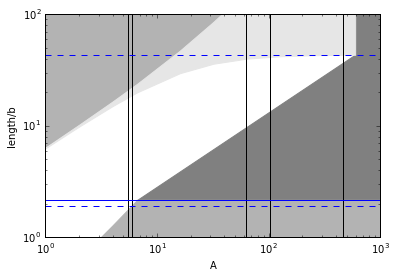

In [165]:
AAs = 2.0**np.arange(11)
AAs[-1] = gK/b**2/lB**(1/4) * (N0/2/c[0])**(3/4)
AAs[3] = u**(1/2) * gK / tau.n**(3/2)
BBs = (AAs**2/u)**(2/3) / gK**(1/3) * tau.n
Ds = np.where(
    AAs<AAs[3],
    b * (AAs**2/u/gK**4)**(1/2),
    b * (AAs**2/u/gK**2)**(1/3)
    )
rscr = (BBs*gK/c[0]/b)**(1/2) * (1 + BBs/Bs)**(-1/2)
xi = (BBs*gK/c[0]/b)**(1/2) * (1 + BBs/Bs)**(1/4)
for AA in A:
    plt.axvline(AA.n, color='k')

#compact region
col = [0.5]*3
plt.fill_betweenx(Ds[3:]/b, AAs[3:], 1e3, color=col)
plt.fill_between([AAs[-1], 1e3], (lB*2/N0*c[0])**(-1/2)/b, 1e2, color=col)
#random walk
col = [0.7]*3
plt.fill_betweenx(Ds[:4]/b, AAs[:4], 1e3, color=col)
plt.fill_between(AAs, xi/b, 1e2, color=col)
#self avoiding walk
col = [0.9]*3
plt.fill_between(AAs, rscr/b, xi/b, color=col)
plt.axhline(1/tau.n, label=r'thermal $\xi_T$')
plt.axhline(lB/b, ls='--', label=r'Bjerrum $\ell_\mathrm{B}$')
plt.axhline((lB*2/N0*c[0])**(-1/2)/b, ls='--', label='Debye')
#plt.plot(AAs, Ds/b, label=r'electrostatic $D$')
#plt.plot(AAs, rscr/b, label=r'screening $r_\mathrm{scr}$')
#plt.plot(AAs, xi/b, label=r'correlation $\xi$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('A')
plt.ylabel('length/b')
plt.ylim(1,1e2)

In [170]:
AAs[3], 1/tau.n, (1/u/gK**4), u**(1/2)*gK**2

(6.6351852492036585,
 2.1738402720050654,
 0.10370370370370373,
 3.1052950170405937)

In [172]:
AAs[-1], Ds[-1]/b

(595.64832601840362, 43.583176380685209)

In [175]:
(gK/u)**(1/3) * (tau.n/c[0]/b)**(1/2)/b, (N0/2/tau.n)**(3/4)/u**(1/4)/gK**(1/2)

(6.3680760907077563, 17.904654796015073)

In [176]:
lB/b, (lB*2/N0*c[0])**(-1/2)/b

(1.9047619047619044, 43.583176380685231)

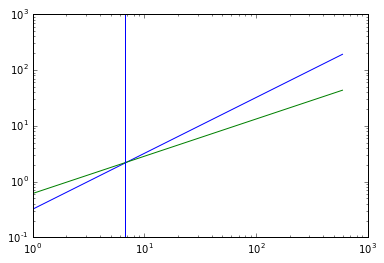

In [143]:
plt.plot(AAs,(AAs**2/u/gK**4)**(1/2))
plt.plot(AAs,(AAs**2/u/gK**2)**(1/3))
plt.xscale('log')
plt.yscale('log')
plt.axvline(AAs[3])

### Estimating $\tau$ from relative size of thermal and electrostatic blobs

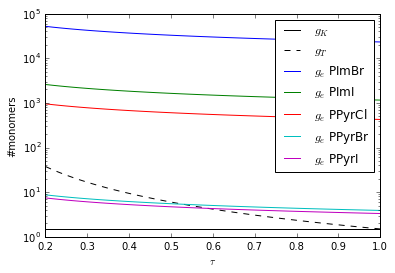

In [20]:
taus = np.linspace(0.2,1)
plt.axhline(gK, color='k', label=r'$g_K$')
plt.plot(taus, gK/taus**2, 'k--', label=r'$g_T$')
for name, BB in zip(names, B):
    plt.plot(taus, (BB.n**3 /gK/taus)**(1/2), label=r'$g_e$ '+name)
plt.legend(loc='upper right')
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel('#monomers')

We express $g_e$ function of $B$ and $\tau$:
$$g_e = \left(\frac{B^3}{g_\mathrm{K}\tau}\right)^{1/2}$$

For the theory to be correct, we need the electrostatic length to be larger than the thermal length, in other words
$$g_e \geq g_T \Leftrightarrow \tau \geq \frac{g_\mathrm{K}}{B}$$

This condition it the most stringent for PPyrI (smallest $B$) and yields:

In [21]:
tau2 = gK/B[-1]
print('tau > {:P}\trelative error: {:0.2f}%\tTheta >= {:P} °C'.format(tau2, 100*tau2.s/tau2.n, constants.K2C(T/(1-tau2))))

tau > 0.5883±0.0016	relative error: 0.27%	Theta >= 451.0±2.8 °C


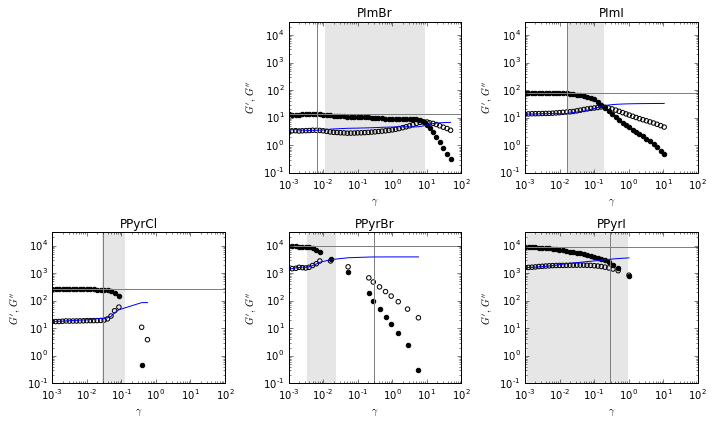

In [46]:
plt.figure(figsize=(10,6))
for i,(a,name, gc0, gc,gth) in enumerate(zip(sweeps,names, gamma_c0, gamma_c, (Ec0/(n*N0) * (B/tau**3)**(1/2) + 1)**2 -1)):
    plt.subplot(2,3,2+i)
    plt.title(name)
    plt.axvspan(gc0.n,gc.n, color=(0.9,0.9,0.9), zorder=-1)
    plt.axhline(a[0,1],color=[0.5]*3)
    plt.axvline(gth.n,color=[0.5]*3)
    plt.scatter(a[:,0], a[:,1], facecolors='k')
    plt.scatter(a[:,0], a[:,2], edgecolors='k', facecolors='none')
    plt.plot(a[:,0], a[np.argmax(a[:,1]),2] + 0.25*(a[:,1].max() - a[:,1]))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-3,1e2)
    plt.ylim(1e-1,3e4)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$G^\prime,\, G^{\prime\prime}$')
plt.tight_layout()

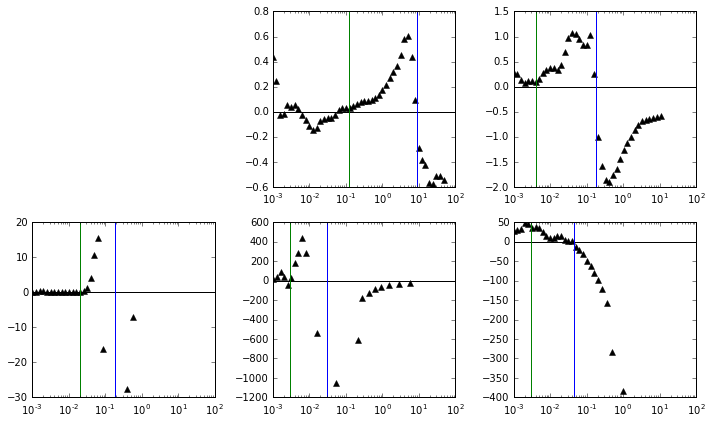

In [25]:
plt.figure(figsize=(10,6))
for i,(a,g,gc,g0) in enumerate(zip(sweeps, G,gamma_c, [1.25e-1,4e-3,2e-2,3e-3,3e-3])):
    plt.subplot(2,3,2+i)
    plt.plot(a[:,0], np.gradient(a[:,2]), 'k^')
    plt.axhline(0, color='k')
    plt.axvline(gc.n, color='b')
    plt.axvline(g0, color='g')
    plt.xscale('log')
    plt.xlim(1e-3,1e2)
plt.tight_layout()

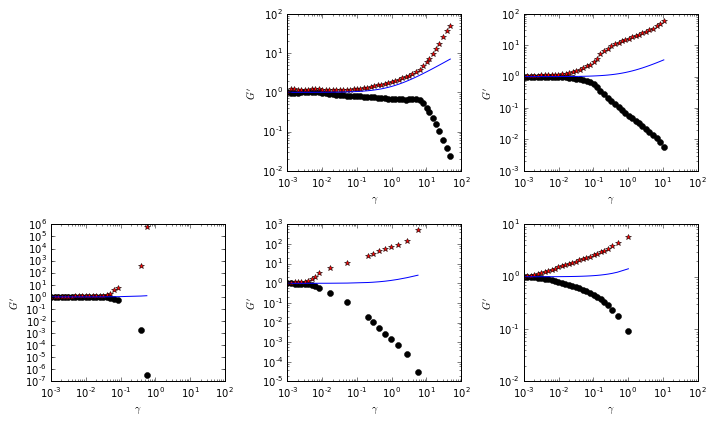

In [56]:
plt.figure(figsize=(10,6))
for i,a in enumerate(sweeps):
    plt.subplot(2,3,2+i)
    gg = np.abs(a[:,1]+1j*a[:,1])
    plt.plot(a[:,0], gg/gg[0], 'ko')
    plt.plot(a[:,0], a[:,2]/a[0,2]/(gg/gg[0]), '*r')
    plt.plot(a[:,0], (a[:,0]+1)**(1/2), 'b-')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-3,1e2)
    #plt.ylim(1e-1,3e4)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$G^\prime$')
plt.tight_layout()

### Extention thresholds function of B

$$\begin{array}{rcl}
\gamma_0+1 &=& \left(\frac{N}{g}\right)^{1/2}\\
\gamma_1+1 &=& \left(\frac{N}{g}\right)^{1/2} \left(\frac{g}{g_\mathrm{scr}}\right)^{2/5}\\
\gamma_2+1 &=& \left(\frac{N}{g}\right)^{1/2} \left(\frac{g}{g_\mathrm{scr}}\right)^{2/5} B
\end{array}$$

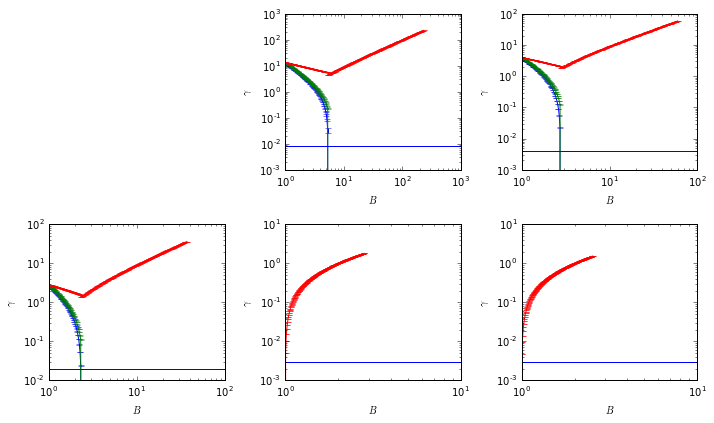

In [101]:
plt.figure(figsize=(10,6))
for i,(BB,nn,cc, gc) in enumerate(zip(B0, n, c, [8e-3,4e-3,2e-2,3e-3,3e-3])):
    plt.subplot(2,3,2+i)
    Bs = np.logspace(0,np.log10(BB.n),200, base=10)
    gamma_0 = (nn*N0 / (Bs**3/(cc*b**3) * (1 + Bs*u*2/N0)**(3/4)))**(1/2) - 1
    gamma_1 = np.where(
        gamma_0>0, 
        (gamma_0+1) * (1 + Bs*u*2/N0)**(1/2),
        ((nn*N0)**2 * b**3 / cc / Bs**3 * (1 + Bs*u*2/N0))**(1/5)
        ) -1
    gamma_2 = np.maximum(1, (gamma_1+1)) * Bs -1
    plt.errorbar(Bs, unp.nominal_values(gamma_0), unp.std_devs(gamma_0))
    plt.errorbar(Bs, unp.nominal_values(gamma_1), unp.std_devs(gamma_1))
    plt.errorbar(Bs, unp.nominal_values(gamma_2), unp.std_devs(gamma_2))
    plt.xlabel(r'$B$')
    plt.ylabel(r'$\gamma$')
    plt.xscale('log')
    plt.yscale('log')
    plt.axhline(gc)
    #plt.axvline((b**6 * (nn.n*N0)**4 * N0/ (2*u*cc))**(1/9))
plt.tight_layout()